In [1]:
%load_ext autoreload
%autoreload 2

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.aqua.utils.backend_utils import is_aer_provider
from qiskit.aqua.components.variational_forms import VariationalForm

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmqx2


In [2]:
dist = 1.7
driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
qubitOp = ferOp.mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
exact_solution = NumPyEigensolver(qubitOp).run()
#exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
#print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
#print(num_spin_orbitals, num_particles)
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
)
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity',
    excitation_type="s"
)

from qiskit.aqua.operators import (OperatorBase, ExpectationBase, ExpectationFactory, StateFn,
                                   CircuitStateFn, LegacyBaseOperator, ListOp, I, CircuitSampler)
backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=None,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

In [3]:
from time import time
def _energy_evaluation(qubitOp, var_form, quantum_instance, x, y):
    """Evaluate energy at given parameters for the variational form.

    This is the objective function to be passed to the optimizer that is used for evaluation.

    Args:
        parameters: The parameters for the variational form.

    Returns:
        Energy of the hamiltonian of each parameter.


    Raises:
        RuntimeError: If the variational form has no parameters.
    """
    num_parameters = var_form.num_parameters
    _var_form_params = ParameterVector('θ', length=var_form.num_parameters)
    wave_function = var_form.construct_circuit(_var_form_params)
    expectation = ExpectationFactory.build(operator=qubitOp.to_opflow(), backend=quantum_instance, include_custom=False)
    observable_meas = expectation.convert(StateFn(qubitOp.to_opflow(), is_measurement=True))
    ansatz_circuit_op = CircuitStateFn(wave_function)

    parameter_sets = np.reshape(np.array([x,y]), (-1, num_parameters))
    # Create dict associating each parameter with the lists of parameterization values for it
    param_bindings = dict(zip(_var_form_params, parameter_sets.transpose().tolist()))  # type: Dict
    _circuit_sampler = CircuitSampler(quantum_instance, param_qobj=is_aer_provider(quantum_instance.backend))
    expect_op = observable_meas.compose(ansatz_circuit_op).reduce()

    start_time = time()
    sampled_expect_op = _circuit_sampler.convert(expect_op, params=param_bindings)
    means = np.real(sampled_expect_op.eval())
    end_time = time()
    
    #print('Energy evaluation returned {} - {} (ms)'.format(means[0], (end_time - start_time) * 1000))

    return means if len(means) > 1 else means[0]

In [76]:
_energy_evaluation(qubitOp, var_form, quantum_instance, parameters)

Energy evaluation returned -1.5176090667746327 - 13.551473617553711 (ms)


-1.5176090667746327

In [4]:
backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=None,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

n = 100
x = np.linspace(-pi, pi, n)
y = np.linspace(-pi, pi, n)
X, Y = np.meshgrid(x, y)
sim_E = np.zeros(X.shape)
for i in range(len(x)):
    print(i)
    for j in range(len(y)):
        sim_E[i,j] = _energy_evaluation(qubitOp, var_form, quantum_instance, x[i], y[j])

optimizer = COBYLA(maxiter=1000)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(backend)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f639ac5bf50>>


Process ForkProcess-22:
Process ForkProcess-26:
Process ForkProcess-23:
Process ForkProcess-28:
Process ForkProcess-27:
Process ForkProcess-21:
Process ForkProcess-25:
Process ForkProcess-24:
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/oryosu/anaconda3/envs/qiskit/lib/pytho

In [13]:
ret['optimal_point'][1]

6.974934367372367e-05

In [6]:
ret

{'optimal_parameters': {Parameter(θ[0]): 6.974934367372367e-05, Parameter(θ[1]): 7.165911705487854e-05}, 'optimal_point': array([6.97493437e-05, 7.16591171e-05]), 'optimal_value': -1.5176090582436566, 'optimizer_evals': 25, 'optimizer_time': 0.12793636322021484, 'eigenvalue': (-1.5176090582436566+0j), 'eigenstate': array([6.97493430e-05+0.00000000e+00j, 9.99999995e-01+2.38764562e-12j,
       4.99817635e-09+0.00000000e+00j, 7.16591170e-05+1.71096578e-16j]), 'cost_function_evals': 25}

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


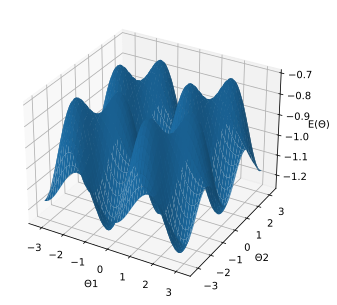

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Θ1")
ax.set_ylabel("Θ2")
ax.set_zlabel("E(Θ)")
ax.plot_surface(X, Y, sim_E)
ax.plot([ret['optimal_point'][0]], [ret['optimal_point'][1]], [ret['eigenvalue']], marker="o",linestyle='None')
plt.savefig("E_sim_17.png")
plt.show()

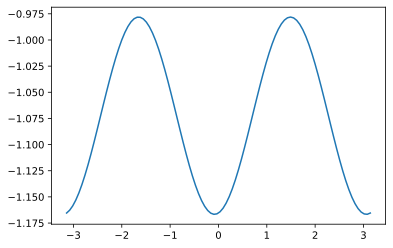

In [12]:
plt.plot(X[50,:], sim_E[50, :])
plt.savefig("E_sim_y0_17.png")

In [14]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

n = 100
x = np.linspace(-pi, pi, n)
y = np.linspace(-pi, pi, n)
X, Y = np.meshgrid(x, y)
E = np.zeros(X.shape)
for i in range(len(x)):
    print(i)
    for j in range(len(y)):
        E[i,j] = _energy_evaluation(qubitOp, var_form, quantum_instance, x[i], y[j])
optimizer = COBYLA(maxiter=1000)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(backend)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f63981a0a90>>


In [15]:
ret

{'optimal_parameters': {Parameter(θ[0]): 0.0058220252195983055, Parameter(θ[1]): 0.0621799641978378}, 'optimal_point': array([0.00582203, 0.06217996]), 'optimal_value': -1.1728196915699844, 'optimizer_evals': 27, 'optimizer_time': 1.2925901412963867, 'eigenvalue': (-1.1728196915699844+0j), 'eigenstate': {'01': 1018, '11': 6}, 'cost_function_evals': 27}

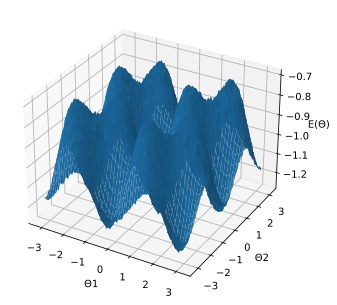

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Θ1")
ax.set_ylabel("Θ2")
ax.set_zlabel("E(Θ)")
ax.plot_surface(X, Y, E)
plt.savefig("E_real_17.png")
plt.show()

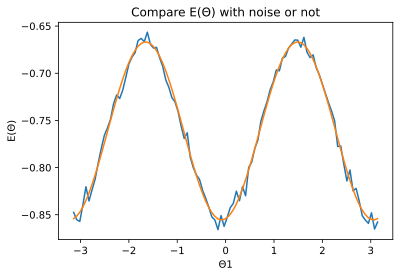

In [19]:
plt.plot(X[50,:], E[50, :]+repulsion_energy)
plt.plot(X[50, :], sim_E[50, :]+repulsion_energy)
plt.title("Compare E(Θ) with noise or not")
plt.xlabel("Θ1")
plt.ylabel("E(Θ)")
#plt.xlim([-0.5, 0.5])
#plt.ylim([-1.05, -1.02])
plt.savefig("E_y0_compare_17.png")

In [12]:
E.min(axis=0)

array([-1.52794468, -1.53279478, -1.54270941, -1.53811195, -1.54419022,
       -1.54201902, -1.52662889, -1.52167428, -1.49527664, -1.4865704 ,
       -1.46735335, -1.44028045, -1.40756171, -1.38095101, -1.34802279,
       -1.3317192 , -1.27330054, -1.26047476, -1.21698413, -1.19498384,
       -1.16065039, -1.12807709, -1.11979133, -1.10225293, -1.07853625,
       -1.08257491, -1.0875914 , -1.1013364 , -1.12193505, -1.13749696,
       -1.16766126, -1.18290272, -1.2251943 , -1.25490253, -1.28027558,
       -1.32247654, -1.34794527, -1.38403688, -1.41192351, -1.42960034,
       -1.45862138, -1.48134323, -1.49304301, -1.50625789, -1.51498636,
       -1.52980779, -1.53381823, -1.53259141, -1.5318013 , -1.52903101,
       -1.52548197, -1.5504528 , -1.52760316, -1.52976977, -1.53170227,
       -1.52017694, -1.51780687, -1.5041622 , -1.49577791, -1.47500485,
       -1.45543737, -1.40503505, -1.40946065, -1.36679054, -1.34200389,
       -1.31012979, -1.26573618, -1.22243129, -1.20221764, -1.16